In [1]:
import sys
sys.path.append('..')

import numpy as np
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
import glob
import seaborn as sns

from model import *
from utils import *
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%load_ext autoreload
%autoreload 2

In [2]:
def load_model(model, exp_name, ckpt=0, final=False, best=False, file_name=None):
    if file_name:
        fn = file_name
    elif best:
        fn = 'best-model.pth'
    elif final:
        fn = 'final-model.pth'
    else:
        fn = f'checkpoint-{ckpt}.pth'
    model_path = f'/mnt/cfs/sihaozhe/ss-dfd/exp/{exp_name}/model/{fn}'
    model_dict = torch.load(model_path)
    state_dict = model_dict['model']
    model.load_state_dict(state_dict)
    return model_dict['iter']

In [3]:
def eval_depth(pred, gt):
    error = torch.abs(gt - pred)
    AbsRel = torch.mean(error / gt)
    SqRel = torch.mean(error ** 2 / gt)
    RMSE = torch.sqrt(torch.mean(error ** 2))
    RMSE_log = torch.sqrt(torch.mean(torch.abs(torch.log10(gt+1e-8) - torch.log10(pred+1e-8)) ** 2))
    gt_pred = gt/pred
    pred_gt = pred/gt
    acc = torch.max(gt_pred, pred_gt)
    delta1 = torch.sum(acc < 1.25)/(acc.shape[-1] * acc.shape[-2])
    delta2 = torch.sum(acc < 1.25**2)/(acc.shape[-1] * acc.shape[-2])    
    delta3 = torch.sum(acc < 1.25**3)/(acc.shape[-1] * acc.shape[-2])
    return AbsRel, SqRel, RMSE, RMSE_log, delta1, delta2, delta3

def eval_aif(inp):
    dy = inp[:, :, :, :] - F.pad(inp[:, :, :-1, :], (0, 0, 1, 0))
    dx = inp[:, :, :, :] - F.pad(inp[:, :, :, :-1], (1, 0, 0, 0))
    MG = torch.mean(torch.sqrt((dx ** 2 + dy ** 2)/2), dim=[1,2,3]) # Large -> Better
    SF = torch.sqrt(torch.mean(dx ** 2, dim=[1,2,3]) + torch.mean(dy ** 2, dim=[1,2,3])) # Large -> Better
    return MG.mean(), SF.mean()

In [4]:
def dpt_post_op(dpt, post_op, near=0.1, far=10.):
    if post_op == 'clip':
        dpt = torch.clip(dpt, 0, 1).detach().cpu()
    elif post_op == 'norm':
        dpt_local_min = torch.min(dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
        dpt_local_max = torch.max(dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
        norm_dpt_ = dpt / (dpt_local_max + 1e-8)
        # norm_dpt_ = (dpt - dpt_local_min)/(dpt_local_max - dpt_local_min + 1e-8)
        norm_dpt = norm_dpt_ * (far - near) + near
        dpt = norm_dpt.detach().cpu()
    return dpt

In [5]:
def eval_model(model_name, dl, n_vis, model):
    exp_name = f'{model_name}'
    n_iter = load_model(model, exp_name, ckpt, best=best)
    model = model.cuda()
    df_model = dict(Setting=[], n_img=[], AbsRel=[], SqRel=[], RMSE=[], RMSE_log=[], delta1=[], delta2=[], delta3=[], SF=[], MG=[], GT_SF=[], GT_MG=[])#, CSF=[], CMG=[])
    for i, batch in enumerate(dl):
        with torch.no_grad():
            raw_aif_dpt = model(batch['rgb_fd'].cuda())
            raw_aif = raw_aif_dpt[:, :-1]
            raw_dpt = raw_aif_dpt[:, -1]
        pred_dpt = dpt_post_op(raw_dpt, post_op)
        pred_dpt = upsample(pred_dpt.unsqueeze(0)).squeeze(0)
        pred_aif = torch.clip(raw_aif, 0, 1)
        dpt_gt = batch['dpt'][0]
        aif_gt = batch['aif']
        with torch.no_grad():
            raw_aif_dpt = model(batch['rgb_fd'].cuda())
            raw_aif = raw_aif_dpt[:, :-1]
            raw_dpt = raw_aif_dpt[:, -1]
        pred_dpt = dpt_post_op(raw_dpt, post_op)
        pred_dpt = upsample(pred_dpt.unsqueeze(0)).squeeze(0)
        pred_aif = torch.clip(raw_aif, 0, 1)
        dpt_gt = batch['dpt'][0]
        aif_gt = batch['aif']

        # B, FS, C, H, W = batch['output'].shape
        # dpt = pred_dpt.expand(FS, H, W)
        # fd = batch['output_fd'].view(-1, 1, 1).expand_as(dpt)
        # defocus = camera.getCoC(dpt, fd).unsqueeze(1)
        # inp_fs = batch['rgb_fd'][:, :, :-1]
        # clear_idx = torch.argmin(defocus.view(B, FS, 1, H, W).expand(B, FS, C, H, W), dim=1, keepdim=True)
        # coarse_aif = torch.gather(inp_fs, 1, clear_idx).squeeze(1)

        MG, SF = eval_aif(pred_aif.cpu())
        GT_MG, GT_SF = eval_aif(aif_gt[:,:,::2,::2])
        # CMG, CSF = eval_aif(coarse_aif.cpu())

        AbsRel, SqRel, RMSE, RMSE_log, delta1, delta2, delta3 = eval_depth(pred_dpt, dpt_gt)
        # print(AbsRel)
        df_model['n_img'].append(float(n_vis))
        df_model['AbsRel'].append(AbsRel.numpy())
        df_model['SqRel'].append(SqRel.numpy())
        df_model['RMSE'].append(RMSE.numpy())
        df_model['RMSE_log'].append(RMSE_log.numpy())
        df_model['delta1'].append(delta1.numpy())
        df_model['delta2'].append(delta2.numpy())
        df_model['delta3'].append(delta3.numpy())
        df_model['MG'].append(MG.numpy())
        df_model['SF'].append(SF.numpy())
        # df_model['CMG'].append(CMG.numpy())
        # df_model['CSF'].append(CSF.numpy())
        df_model['GT_MG'].append(GT_MG.numpy())
        df_model['GT_SF'].append(GT_SF.numpy())
        # df_model['n_img'].append(n_vis)
        df_model['Setting'].append(model_name)#+'_'+str(n_iter).zfill(5)+f'_trans{trans}')
    df_model = pd.DataFrame.from_dict(df_model)
    return df_model

In [6]:
DSLR = False
if DSLR:
    data_path = '/mnt/cfs/sihaozhe/data/dfd_datasets/dfd_indoor/dfd_dataset_indoor_N8'
else:
    data_path = "/mnt/cfs/sihaozhe/data/NYUv2"
device = 4
BS = 1
use_cuda = True

In [152]:
# dataloaders = []
# for trans in [True, False]:
#     if trans:
#         fd = [2, 3, 4.5, 5, 7]
#     else:
#         fd = [1, 1.5, 2.5, 4, 6]
#     dataset_config = {
#         'root_dir': data_path,
#         'shuffle': False,
#         'img_num':  5, 
#         'visible_img': 5,
#         'focus_dist': fd,
#         'recon_all': True,
#         'RGBFD': True,
#         'DPT': True,
#         'AIF': True,
#         'near': 0.1,
#         'far':10.,
#         'scale':1,
#     }
#     if not DSLR:
#         dataset_config.update(trans=trans)
#     train_dl, _, test_dl = load_data(dataset_config, "NYU", BS)
#     dataloaders.append(test_dl)

In [153]:
# camera = ThinLenCamera(pixel_size=5.6e-6)
camera = ThinLenCamera(fnumber=1.2, focal_length=17*1e-3, pixel_size=1.2e-5)
render = GaussPSF(7)
render.cuda()
model = FUNet(4, 4)

In [154]:
torch.cuda.set_device(device)

In [158]:
model_names = ['NYU_100_FS3', 'NYU_100_FS5', 'NYU_100_FS7']
ckpt = 1500
final = False
best=True
post_op = 'norm'    
upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

In [159]:
df_models_list = []
for i in trange(2, 11):
    dataset_config = {
        'root_dir': data_path,
        'shuffle': False,
        'img_num':  100, 
        'visible_img': i,
        'focus_dist': np.linspace(1, 9, 100),
        'recon_all': False,
        'RGBFD': True,
        'DPT': True,
        'AIF': True,
        'near': 0.1,
        'far':10.,
        'scale':1,
    }
    _, _, test_dl = load_data(dataset_config, "NYU100", 1)
    for model_name in tqdm(model_names):
        df_model = eval_model(model_name, test_dl, i, model)
        df_models_list.append(df_model)
df_models = pd.concat(df_models_list)   

  0%|          | 0/9 [00:00<?, ?it/s]

2 out of 100 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


  0%|          | 0/3 [00:00<?, ?it/s]

3 out of 100 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


  0%|          | 0/3 [00:00<?, ?it/s]

4 out of 100 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


  0%|          | 0/3 [00:00<?, ?it/s]

5 out of 100 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


  0%|          | 0/3 [00:00<?, ?it/s]

6 out of 100 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


  0%|          | 0/3 [00:00<?, ?it/s]

7 out of 100 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


  0%|          | 0/3 [00:00<?, ?it/s]

8 out of 100 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


  0%|          | 0/3 [00:00<?, ?it/s]

9 out of 100 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


  0%|          | 0/3 [00:00<?, ?it/s]

10 out of 100 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


  0%|          | 0/3 [00:00<?, ?it/s]

In [160]:
for columns in tqdm(df_models.columns):
    if columns != 'Setting':
        df_models[columns] = df_models[columns].astype(np.float64)

  0%|          | 0/13 [00:00<?, ?it/s]

In [253]:
df_model_collect = df_models.groupby(['Setting', 'n_img']).mean().reset_index()
df_model_collect['n_img'] = df_model_collect['n_img'].astype(int)
df_model_collect.loc[df_model_collect.Setting=='NYU_100_FS3', 'Setting'] = 'FS3'
df_model_collect.loc[df_model_collect.Setting=='NYU_100_FS5', 'Setting'] = 'FS5'
df_model_collect.loc[df_model_collect.Setting=='NYU_100_FS7', 'Setting'] = 'FS7'
df_model_collect

,Setting,n_img,AbsRel,SqRel,RMSE,RMSE_log,delta1,delta2,delta3,SF,MG,GT_SF,GT_MG
0,FS3,2,0.594622,1.641396,0.924675,0.199012,0.695258,0.800870,0.854015,0.121100,0.034085,0.146153,0.042774
1,FS3,3,0.411969,1.051161,0.633563,0.153017,0.808206,0.873177,0.904207,0.126502,0.035934,0.146153,0.042774
2,FS3,4,0.331858,0.821118,0.507559,0.128638,0.855755,0.906127,0.929285,0.128425,0.036478,0.146153,0.042774
3,FS3,5,0.295268,0.728365,0.444628,0.115291,0.877475,0.924419,0.943521,0.127357,0.035814,0.146153,0.042774
4,FS3,6,0.271960,0.686732,0.414170,0.105386,0.895875,0.939701,0.954710,0.128318,0.036315,0.146153,0.042774
5,FS3,7,0.262186,0.681190,0.396078,0.100613,0.905438,0.946124,0.960177,0.128609,0.036456,0.146153,0.042774
6,FS3,8,0.253652,0.675067,0.379118,0.095883,0.914061,0.953061,0.966026,0.127961,0.036056,0.146153,0.042774
7,FS3,9,0.247772,0.670740,0.369096,0.092395,0.920896,0.959351,0.970812,0.128160,0.036089,0.146153,0.042774
8,FS3,10,0.249800,0.678796,0.370307,0.092745,0.921566,0.959376,0.970765,0.128567,0.036273,0.146153,0.042774
9,FS5,2,0.546742,1.243718,0.894730,0.191353,0.687212,0.798251,0.852039,0.124698,0.035445,0.146153,0.042774


In [19]:
# df_model_collect.to_csv('fs_abl.csv')
df_model_collect = pd.read_csv('fs_abl.csv', index_col=0)
df_fs = df_model_collect
df_fs = df_fs.loc[df_fs.n_img%2!=0]

In [26]:
df_fs

,Setting,n_img,AbsRel,SqRel,RMSE,RMSE_log,delta1,delta2,delta3,SF,MG,GT_SF,GT_MG
1,NYU_100_FS3,3.0,0.411969,1.051161,0.633563,0.153017,0.808206,0.873177,0.904207,0.126502,0.035934,0.146153,0.042774
3,NYU_100_FS3,5.0,0.295268,0.728365,0.444628,0.115291,0.877475,0.924419,0.943521,0.127357,0.035814,0.146153,0.042774
5,NYU_100_FS3,7.0,0.262186,0.681190,0.396078,0.100613,0.905438,0.946124,0.960177,0.128609,0.036456,0.146153,0.042774
7,NYU_100_FS3,9.0,0.247772,0.670740,0.369096,0.092395,0.920896,0.959351,0.970812,0.128160,0.036089,0.146153,0.042774
10,NYU_100_FS5,3.0,0.419806,1.065201,0.653586,0.155397,0.803644,0.872675,0.901100,0.127739,0.036084,0.146153,0.042774
12,NYU_100_FS5,5.0,0.317165,0.876390,0.477257,0.119703,0.885814,0.927489,0.940215,0.130810,0.037253,0.146153,0.042774
14,NYU_100_FS5,7.0,0.269704,0.768907,0.398618,0.102106,0.917206,0.948047,0.957278,0.132314,0.037825,0.146153,0.042774
16,NYU_100_FS5,9.0,0.263444,0.831547,0.367912,0.095127,0.928796,0.955909,0.966676,0.133377,0.038103,0.146153,0.042774
19,NYU_100_FS7,3.0,0.408520,0.925740,0.658157,0.155305,0.789043,0.863929,0.896929,0.128622,0.036713,0.146153,0.042774
21,NYU_100_FS7,5.0,0.330175,0.928812,0.500652,0.123357,0.889703,0.926419,0.936777,0.130877,0.037344,0.146153,0.042774


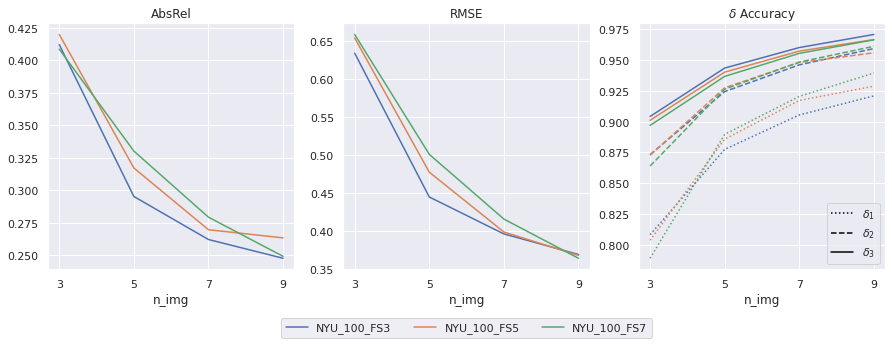

In [27]:
sns.set_theme()
fig, axes = plt.subplots(1, 3, figsize=(15,15), sharey=False)

sns.lineplot(data=df_fs, x='n_img', y='AbsRel', hue='Setting', ax=axes[0], legend=False)
sns.lineplot(data=df_fs, x='n_img', y='RMSE', hue='Setting',  ax=axes[1])
sns.lineplot(data=df_fs, x='n_img', y='delta1', hue='Setting',  ax=axes[2], ls=':', legend=False)
sns.lineplot(data=df_fs, x='n_img', y='delta2', hue='Setting',  ax=axes[2], ls='--', legend=False)
sns.lineplot(data=df_fs, x='n_img', y='delta3', hue='Setting',  ax=axes[2], legend=False)

axes[0].set_box_aspect(1)
axes[1].set_box_aspect(1)
axes[2].set_box_aspect(1)
axes[0].set_ylabel('')
axes[0].set_xticks([3, 5, 7, 9])
axes[1].set_ylabel('')
axes[1].set_xticks([3, 5, 7, 9])
axes[2].set_ylabel('')
axes[2].set_xticks([3, 5, 7, 9])
axes[0].set_title('AbsRel')
axes[1].set_title('RMSE')
axes[2].set_title('$\delta$ Accuracy')
axes[1].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.3))

solid_line = mlines.Line2D([], [], color='black', label='$\delta_3$')
dash_line = mlines.Line2D([], [], color='black', ls='--', label='$\delta_2$')
dot_line = mlines.Line2D([], [], color='black', ls=':', label='$\delta_1$')

axes[2].legend(handles=[dot_line, dash_line, solid_line])

plt.show()

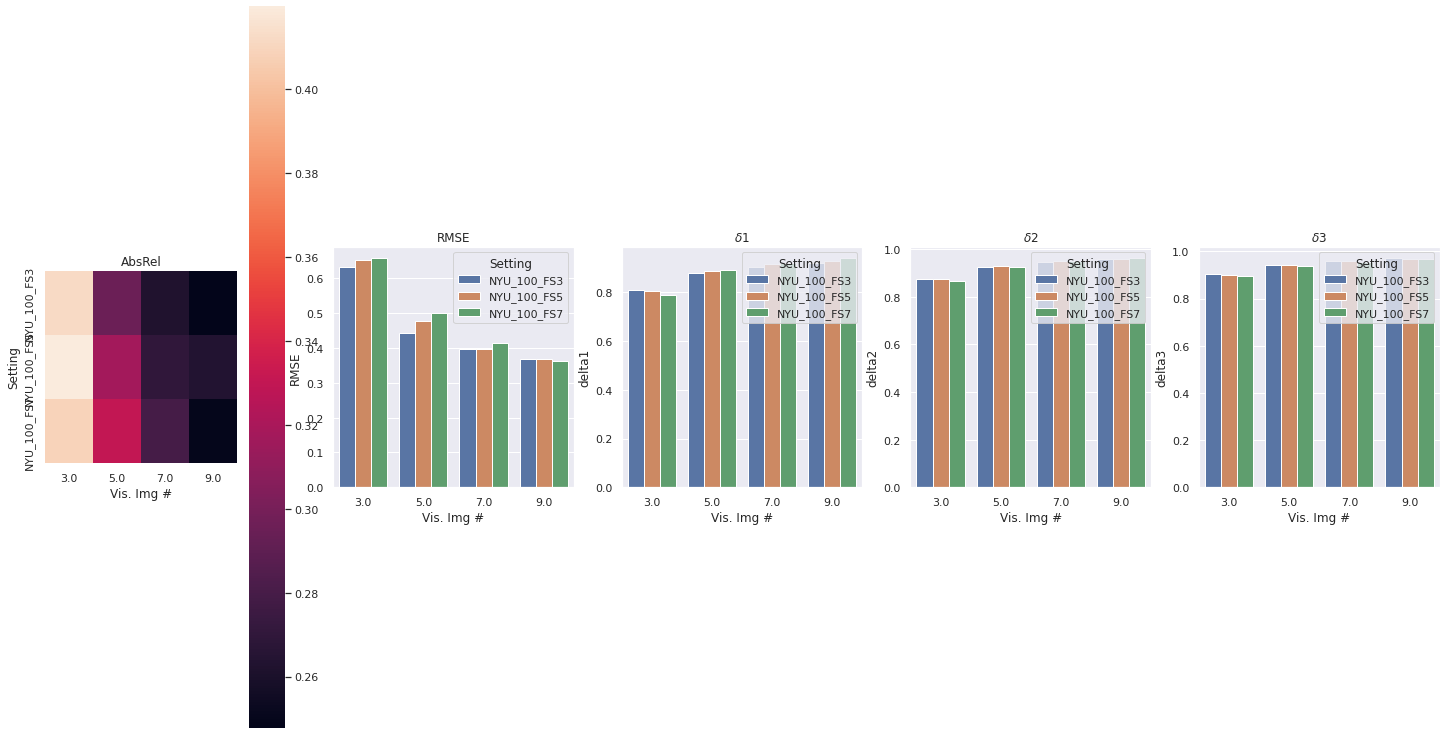

In [32]:
sns.set_theme()
fig, axes = plt.subplots(1, 5, figsize=(25,25), sharey=False)

AbsRel = df_fs.pivot("Setting", "n_img", "AbsRel")
sns.heatmap(AbsRel, ax=axes[0])
sns.barplot(data=df_fs, x='n_img', y='RMSE', hue='Setting',  ax=axes[1])
sns.barplot(data=df_fs, x='n_img', y='delta1', hue='Setting',  ax=axes[2])
sns.barplot(data=df_fs, x='n_img', y='delta2', hue='Setting',  ax=axes[3])
sns.barplot(data=df_fs, x='n_img', y='delta3', hue='Setting',  ax=axes[4])

axes[0].set_box_aspect(1)
axes[1].set_box_aspect(1)
axes[2].set_box_aspect(1)
axes[3].set_box_aspect(1)
axes[4].set_box_aspect(1)

# axes[0].set_ylabel('')
# axes[1].set_ylabel('')
# axes[2].set_ylabel('')
# axes[3].set_ylabel('')
# axes[4].set_ylabel('')

axes[0].set_xlabel('Vis. Img #')
axes[1].set_xlabel('Vis. Img #')
axes[2].set_xlabel('Vis. Img #')
axes[3].set_xlabel('Vis. Img #')
axes[4].set_xlabel('Vis. Img #')

# axes[0].set(ylim=(0.2, 0.45))
# axes[1].set(ylim=(0.3, 0.7))
# axes[2].set(ylim=(0.75, 1.0))
# axes[3].set(ylim=(0.75, 1.0))
# axes[4].set(ylim=(0.75, 1.0))

axes[0].set_title('AbsRel')
axes[1].set_title('RMSE')
axes[2].set_title('$\delta1$')
axes[3].set_title('$\delta2$')
axes[4].set_title('$\delta3$')

# axes[0].legend().set_visible(False)
# axes[1].legend().set_visible(False)
# axes[2].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.3))
# axes[3].legend().set_visible(False)
# axes[4].legend().set_visible(False)

plt.show()
# plt.savefig('paper_img/FS.pdf')

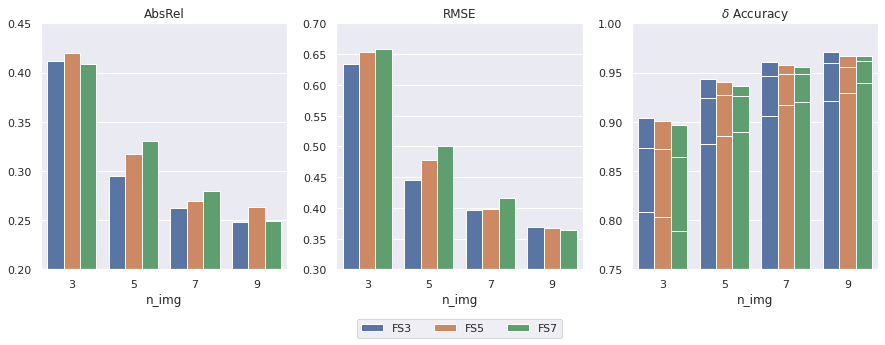

In [257]:
sns.set_theme()
fig, axes = plt.subplots(1, 3, figsize=(15,15), sharey=False)

sns.barplot(data=df_fs, x='n_img', y='AbsRel', hue='Setting', ax=axes[0])
sns.barplot(data=df_fs, x='n_img', y='RMSE', hue='Setting',  ax=axes[1])
sns.barplot(data=df_fs, x='n_img', y='delta3', hue='Setting',  ax=axes[2])
sns.barplot(data=df_fs, x='n_img', y='delta2', hue='Setting',  ax=axes[2])
sns.barplot(data=df_fs, x='n_img', y='delta1', hue='Setting',  ax=axes[2])

axes[0].set_box_aspect(1)
axes[1].set_box_aspect(1)
axes[2].set_box_aspect(1)

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')

axes[0].set(ylim=(0.2, 0.45))
axes[1].set(ylim=(0.3, 0.7))
axes[2].set(ylim=(0.75, 1.0))

axes[0].set_title('AbsRel')
axes[1].set_title('RMSE')
axes[2].set_title('$\delta$ Accuracy')

axes[0].legend().set_visible(False)
axes[2].legend().set_visible(False)
axes[1].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.3))

# solid_line = mlines.Line2D([], [], color='black', label='$\delta_3$')
# dash_line = mlines.Line2D([], [], color='black', ls='--', label='$\delta_2$')
# dot_line = mlines.Line2D([], [], color='black', ls=':', label='$\delta_1$')

# axes[2].legend(handles=[dot_line, dash_line, solid_line])

plt.show()

## Model Eval

In [ ]:
# for batches in zip(*dataloaders):
#     new_batch = {}
#     for key in batches[0].keys():
#         if key != 'dpt' and key != 'aif':
#             new_batch[key] = torch.cat([batches[0][key], batches[1][key]], dim=1)
#         else:
#             new_batch[key] = batches[0][key]
#     break

In [ ]:
# for fn in tqdm(model_list):


In [ ]:
df_mean = df_models.groupby('Setting').mean().reset_index()
df_mean

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(dpt_gt[0].numpy(), cmap='Greys_r')
plt.colorbar(fraction=0.047)
plt.subplot(1, 2, 2)
plt.title('Pred Depth')
plt.imshow(pred_dpt[0].cpu().numpy(), cmap='Greys_r')
plt.colorbar(fraction=0.047)

In [ ]:
plt.title('Clip Pred Depth')
plt.imshow(np.clip(pred_dpt[0].cpu().numpy(), dpt_gt[0].min(), dpt_gt[0].max()), cmap='Greys_r')
plt.colorbar(fraction=0.047)

In [ ]:
B, FS, C, H, W = batch['output'].shape
dpt = pred_dpt[:, ::2, ::2].expand(FS, H, W)
fd = batch['output_fd'].view(-1, 1, 1).expand_as(dpt)
defocus = camera.getCoC(dpt, fd).unsqueeze(1)
plt.figure(figsize=(25, 6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(defocus[i, 0].cpu().numpy())

In [ ]:
inp_fs = batch['rgb_fd'][:, :, :-1]
clear_idx = torch.argmin(defocus.view(B, FS, 1, H, W).expand(B, FS, C, H, W), dim=1, keepdim=True)
coarse_aif = torch.gather(inp_fs, 1, clear_idx).squeeze(1)

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Ground Truth')
plt.imshow(aif_gt[0].cpu().numpy().transpose(1, 2, 0))
plt.subplot(1, 3, 2)
plt.title('Pred AIF')
plt.imshow(pred_aif[0].cpu().numpy().transpose(1, 2, 0))
plt.subplot(1, 3, 3)
plt.title('Coarse AIF')
plt.imshow(coarse_aif[0].numpy().transpose(1, 2, 0))
# plt.savefig('NYU_orig_unsup_vis_aif.png', dpi=200)